# DESI Focalplane Temperature Telemetry

### Imports

In [113]:
import datetime

In [1]:
import numpy as np

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
import astropy.time

In [79]:
import fpoffline.db
import fpoffline.io
import fpoffline.array

### Initialize

In [5]:
DB = fpoffline.db.DB(http_fallback=False)

In [8]:
PETAL = fpoffline.const.get_petal_design()

In [130]:
INDEX = fpoffline.io.get_index()

## Neighbors

Find all neighbors of each device (POS,FID) with temperature sensing.

In [43]:
def getNeighbors():

    sel = PETAL.holes.DEVICE_TYPE != 'GIF'
    typ = PETAL.holes.DEVICE_TYPE[sel]
    x = PETAL.holes[sel].X_PTL.to_numpy()
    y = PETAL.holes[sel].Y_PTL.to_numpy()
    n = len(x)
    neighbors = np.full((n, 6), -1)
    for i in range(n):
        r = np.hypot(x - x[i], y - y[i])
        nid = np.where((r < 11) & (r > 0))[0]
        neighbors[i,:len(nid)] = nid
    return neighbors

neighbors = getNeighbors()

## Read Telemetry

### Utilities

In [6]:
def get_local_midnight(night):
    N = str(night)
    year, month, day = int(N[0:4]), int(N[4:6]), int(N[6:8])
    return astropy.time.Time(datetime.datetime(year, month, day, 12) + datetime.timedelta(hours=19))

In [170]:
def read_telemetry(table, columns, start_night=None, stop_night=None, before=0.5, after=0.5, petal_loc=None, verbose=True):

    if start_night is None:
        # Use yesterday's date by default.
        start_night = int((datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y%m%d'))
        if verbose:
            print(f'Using default start_night {start_night}')
    
    one_day = astropy.time.TimeDelta(1, format='jd')
    start = get_local_midnight(start_night) - before * one_day

    if stop_night is None:
        # Get only one night by default.
        stop = start + (before + after) * one_day
    else:
        stop = get_local_midnight(stop_night) + after * one_day
    nights = (stop - start) / one_day
    
    where = f" where (time_recorded > timestamp '{start}') and (time_recorded < timestamp '{stop}')"
    if petal_loc is not None:
        where += f' and (pcid={petal_loc})'
        petals = [petal_loc]
    else:
        petals = range(10)
    sql = f"select time_recorded,pcid,{columns} from telemetry.{table} {where} order by time_recorded asc"
    maxrows = int(np.round(len(petals) * 1000 * nights))
    df = DB.query(sql, maxrows=maxrows)
    if verbose:
        print(f'Read {len(df)} records from {nights:.1f} nights')
        print(f'{start} - {stop}')
    return df

### Petal ADCs

Read 3000 records from 3.0 nights
2025-04-26 19:00:00 - 2025-04-29 19:00:00


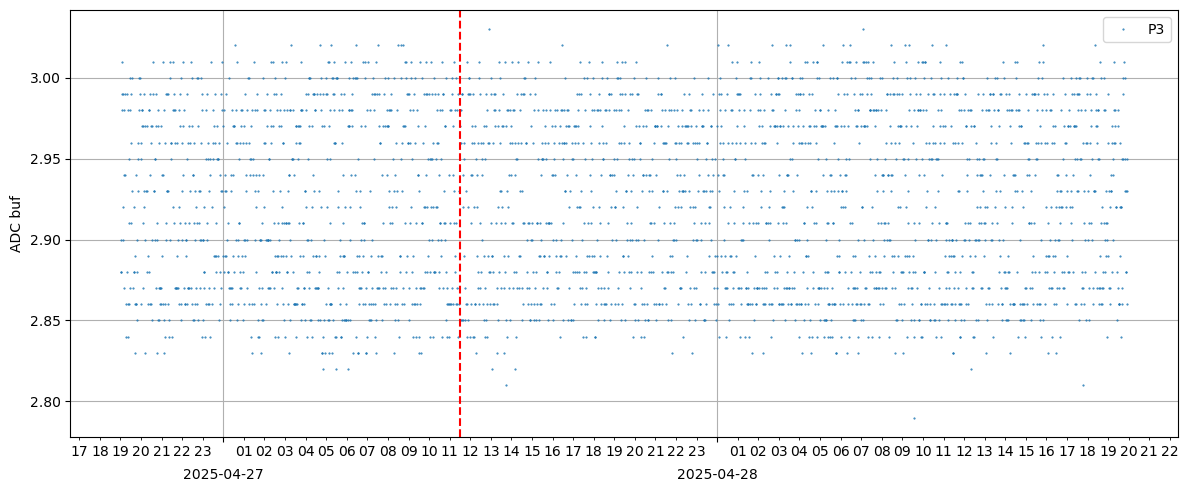

In [194]:
# pc_ptl_sensors adc_split_v vs time
def read_petal(start_night=None, stop_night=None, petal_loc=None, verbose=True, localtime=False):

    fig, ax = plt.subplots(figsize=(12, 5))
    df = read_telemetry('pc_ptl_sensors', 'adc_split_v,adc_buf', start_night=start_night, stop_night=stop_night, petal_loc=petal_loc, verbose=verbose)
    petals = sorted(df.pcid.unique())
    for petal in petals:
        P = df.query(f"pcid=={petal}")
        t = P.time_recorded.values
        if localtime:
            t -= np.timedelta64(7, 'h')
        #ax.plot(t, P.adc_split_v, '.', ms=1, label=f'P{petal}')
        ax.plot(t, P.adc_buf, '.', ms=1, label=f'P{petal}')
    ax.legend(ncol=5)
    ax.grid()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day at midnight
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format as YYYY-MM-DD
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Tick every 3 hours
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H')) # Format as HH:MM
    for label in ax.get_xticklabels(which='major'):
        label.set_y(-0.05)
    ax.set(ylabel='ADC buf')
    ax.axvline(np.datetime64('2025-04-27T11:30:01'), c='r', ls='--')

    plt.tight_layout()
    plt.savefig('buf.png')
    return df

ADC = read_petal(20250426, 20250428, petal_loc=3)

### Posfid Temperatures

In [178]:
def get_temperatures(start_night=None, stop_night=None, petal_loc=None, verbose=True):

    df = read_telemetry('pc_ptl_temps', 'posfid_temps', start_night=start_night, stop_night=stop_night, petal_loc=petal_loc, verbose=verbose)
    petals = sorted(df.pcid.unique())

    ispos = np.zeros(543, int)
    ispos[PETAL.holes.DEVICE_LOC[np.isin(PETAL.holes.DEVICE_TYPE, ('POS','ETC'))]] = 1
    isfid = np.zeros(543, int)
    isfid[PETAL.holes.DEVICE_LOC[np.isin(PETAL.holes.DEVICE_TYPE, ('FIF','GIF'))]] = 1

    result = dict(meta=dict(start_night=start_night, stop_night=stop_night))
    for petal_loc in petals:
        P = df.query(f"pcid=={petal_loc}")
        time = P.time_recorded.values
        ndata = len(time)
        data = np.full((ndata, 514), np.nan, np.float32)
        npos, nfid = np.empty((2, ndata), int)
        for i, d in enumerate(P.posfid_temps):
            locs = np.array([int(k) for k in d.keys()], int)
            valid = locs < len(PETAL.locmap) # ignore DEVICE_LOC=999 on PETAL_LOC=5
            data[i, PETAL.locmap[locs[valid]]] = np.array(list(d.values()))[valid]
            npos[i] = ispos[locs[valid]].sum()
            nfid[i] = isfid[locs[valid]].sum()
            result[petal_loc] = dict(time=time, data=data, npos=npos, nfid=nfid)

    return result

In [164]:
T = get_temperatures(20250529)

Read 1553 records from 1.0 nights
2025-05-29 19:00:00 - 2025-05-30 19:00:00


## Analyze Telemetry

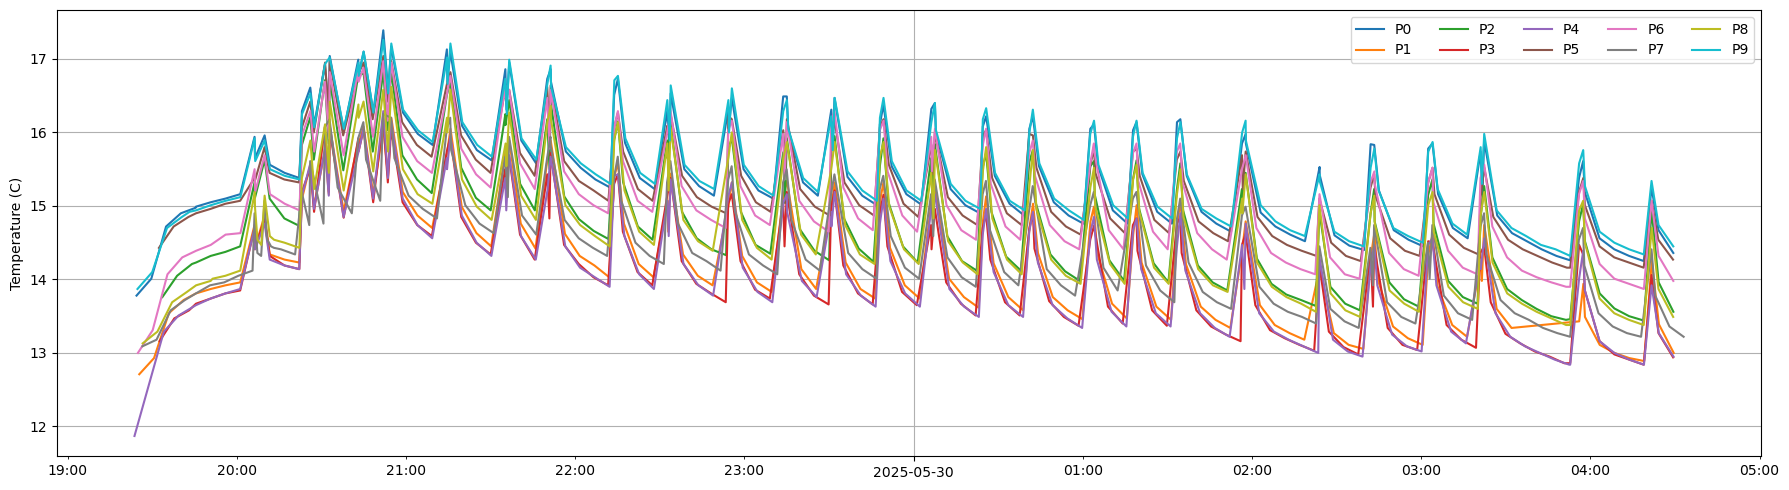

In [147]:
def plot_vs_time(T=T, adjust_calib=False):

    petal_data = { }
    tgrid = None
    T0vec = [ ]
    for k, v in T.items():
        if k == 'meta':
            continue
        t = v['time'] - np.timedelta64(7, 'h')
        if tgrid is None:
            tgrid = np.linspace(t[5].astype('int64'), t[-5].astype('int64'), 32)
        D = v['data']
        Tmed = np.nanmedian(D, axis=1)
        Tgrid = np.interp(tgrid, t.astype('int64'), Tmed)
        T0 = np.mean(Tgrid)
        T0vec.append(T0)
        petal_data[k] = (t, Tmed, T0)
    T0mean = np.mean(T0vec)
    
    fig, ax = plt.subplots(figsize=(18, 5))
    for petal in petal_data:
        t, Tmed, T0 = petal_data[petal]
        if adjust_calib:
            Tmed -= T0 - T0mean
        ax.plot(t, Tmed, '-', label=f'P{petal}')
    ax.legend(ncol=5)
    ax.grid()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day at midnight
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format as YYYY-MM-DD
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Tick every 3 hours
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M')) # Format as HH:MM
    ax.set(ylabel='Temperature (C)')

    plt.tight_layout()
    plt.savefig('T-vs-t.png')

    return np.array(T0vec) - T0mean

dT = plot_vs_time()

In [152]:
np.round(dT, 1)

array([ 0.7, -0.5,  0. , -0.6, -0.6,  0.5,  0.3, -0.4, -0.1,  0.7])

TODO:
 - are shifts ~1C between petals real or calib errors?
 - plot night avg temp vs posid (bimodal?)
 - plot pc_ptl_sensors adc_split_v vs time
 - why are there NaNs in the data?
 - calculate avg temp of neighbors
 - display relative positions of PCBs and theta bodies with temperature color for hot robot and its neighbors

P0: no data at [5797 7500 7411 5766 7369 4039 6739 2956]
P1: no data at [5211 4263]
P2: no data at [5658 7023 5675 6182 6280 5060]
P3: no data at [4980 3966 4596 4882 4792 5300 3972 4056 3757 5018 4243 4744 4588 4316
 5439 4138 2809 3454]
P4: no data at [5473 5031 5115 4386 2351 3028 2668 3360 4228 2792 4763]
P5: no data at [1636 1706 7373 6873 6979 7152 2905]
P6: no data at [10077  3827  6585  1956  1576  6153  6090  5856  6056  6054  6235  3415
  3125]
P7: no data at [3802]
P8: no data at [5957 2065 1690 4585 2480 5472 5036 2060 4569 2433 2547 1719 5478]
P9: no data at [7416 7357 7763 2559  660]


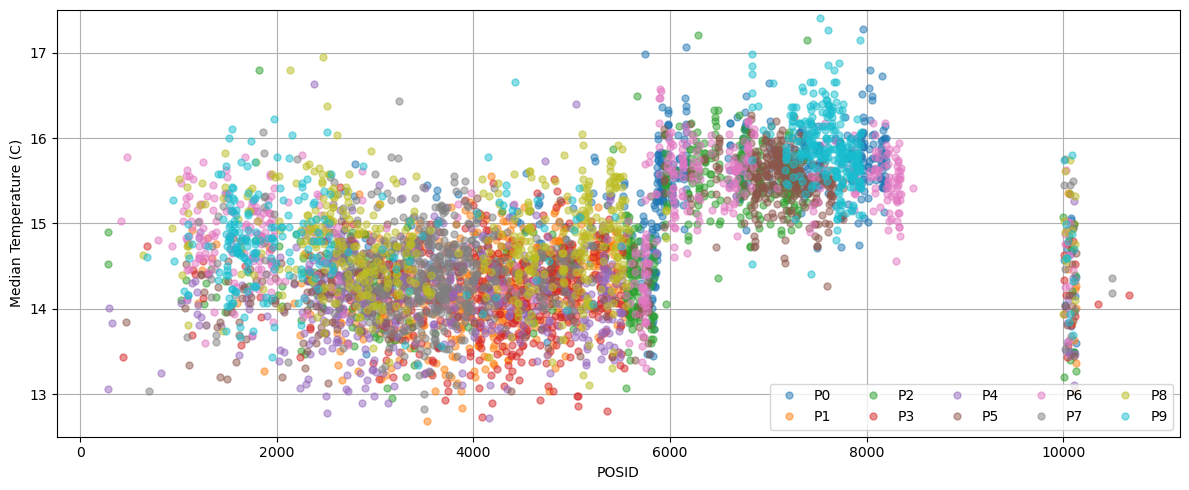

In [151]:
def plot_vs_posid(T=T):

    fig, ax = plt.subplots(figsize=(12, 5))
    for k, v in T.items():
        if k == 'meta':
            continue
        # Calculate locations for each of the 514 entries in Tmed
        loc = 1000 * k + PETAL.holes.DEVICE_LOC
        # Lookup corresponding POSIDs = DEVICE_IDs
        idx = np.searchsorted(INDEX['LOCATION'], loc)
        assert np.all(INDEX['LOCATION'][idx] == loc)
        posid = np.array(INDEX['CAN_ID'][idx])
        
        D = v['data']
        na = np.all(np.isnan(D), axis=0)
        if np.any(na):
            print(f'P{k}: no data at {posid[na]}')
        Tmed = np.full(514, np.nan)
        Tmed[~na] = np.nanmedian(D[:,~na], axis=0)
        
        ax.plot(posid, Tmed, '.', label=f'P{k}', ms=10, alpha=0.5)
        
    ax.legend(ncol=5)
    ax.set(ylim=(12.5,17.5), xlabel='POSID', ylabel='Median Temperature (C)')
    ax.grid()
    plt.tight_layout()
    plt.savefig('T-vs-POSID.png')

plot_vs_posid()

/global/homes/d/dkirkby/.local/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


array([ 0.6520033 , -0.52616596,  0.10468483, -0.5808668 , -0.6137066 ,
        0.2837448 ,  0.3344593 , -0.32083988,  0.01523781,  0.6514549 ],
      dtype=float32)

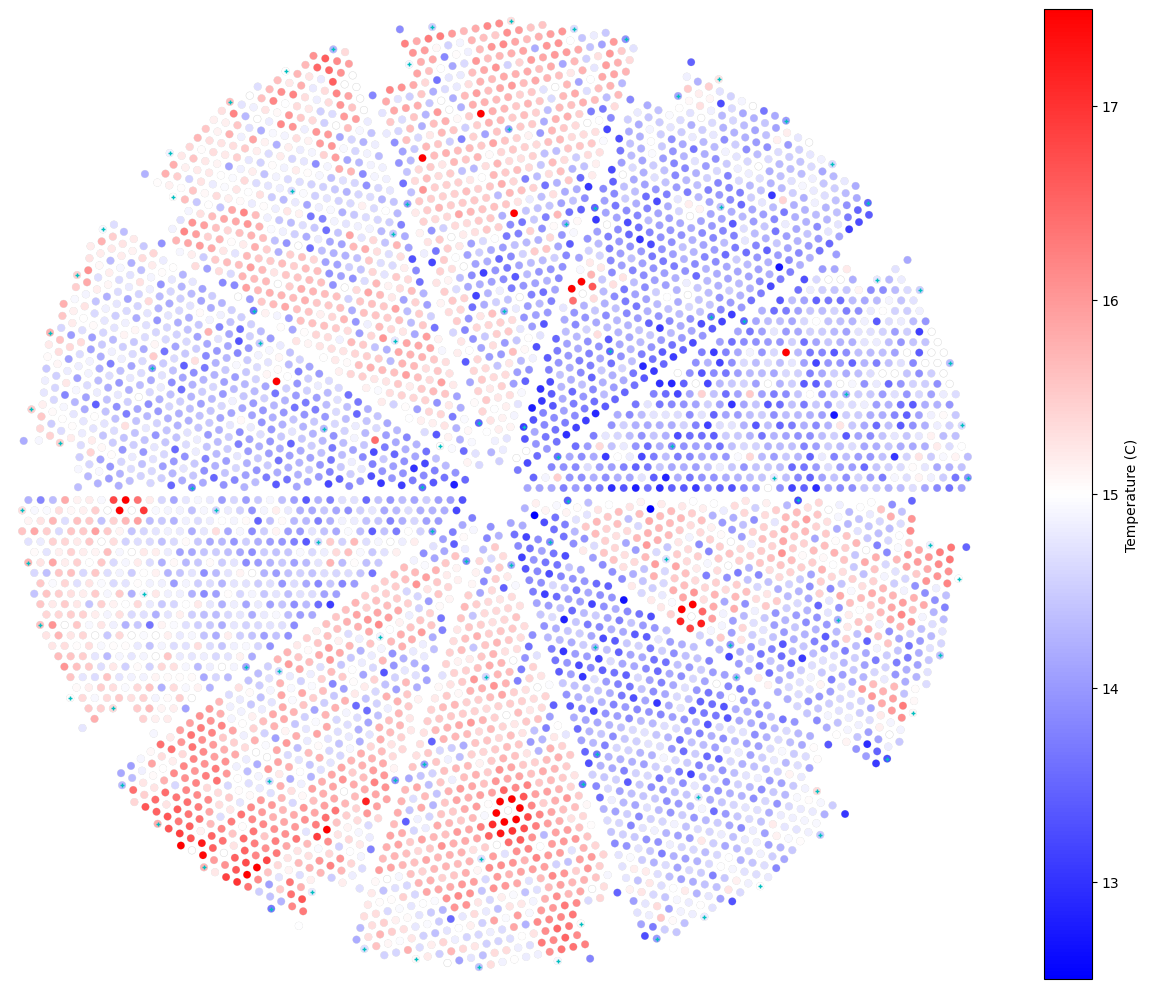

In [145]:
def plot_vs_xy(T=T, adjust_calib=False, vmin=12.5, vmax=17.5):

    petal_data = { }
    T0vec = [ ]
    for k, v in T.items():
        if k == 'meta':
            continue
        D = v['data']
        Tmed = np.nanmedian(D, axis=0)
        T0 = np.nanmean(Tmed)
        T0vec.append(T0)
        petal_data[k] = Tmed
    dT = np.array(T0vec) - np.mean(T0vec)

    fig, ax = plt.subplots(figsize=(13,10))

    # Draw light gray outlines for all locations
    ax.scatter(PETAL.xfp, PETAL.yfp, lw=0.3, fc='none', ec='lightgray', s=30)
    
    # Draw median temperatures for each POS,FIF with telemetry
    for k, petal in enumerate(petal_data):
        Tmed = petal_data[petal]
        if adjust_calib:
            Tmed -= dT[k]
        S = ax.scatter(PETAL.xfp[k], PETAL.yfp[k], c=Tmed, lw=0.3, ec='none', s=30, cmap='bwr', vmin=vmin, vmax=vmax)

    # Draw small black dots for fiducials
    isfid = PETAL.holes.DEVICE_TYPE == 'FIF'
    ax.plot(PETAL.xfp[:,isfid], PETAL.yfp[:,isfid], 'c+', ms=3)

    plt.colorbar(S, ax=ax, label='Temperature (C)')
    ax.set(aspect=1, xlim=(-420, 420), ylim=(-420, 420))
    ax.axis("off")

    plt.tight_layout()
    plt.savefig('T-vs-XY.png')

    return dT

plot_vs_xy()

array([ 0.6520033 , -0.52616596,  0.10468483, -0.5808668 , -0.6137066 ,
        0.2837448 ,  0.3344593 , -0.32083988,  0.01523781,  0.6514549 ],
      dtype=float32)

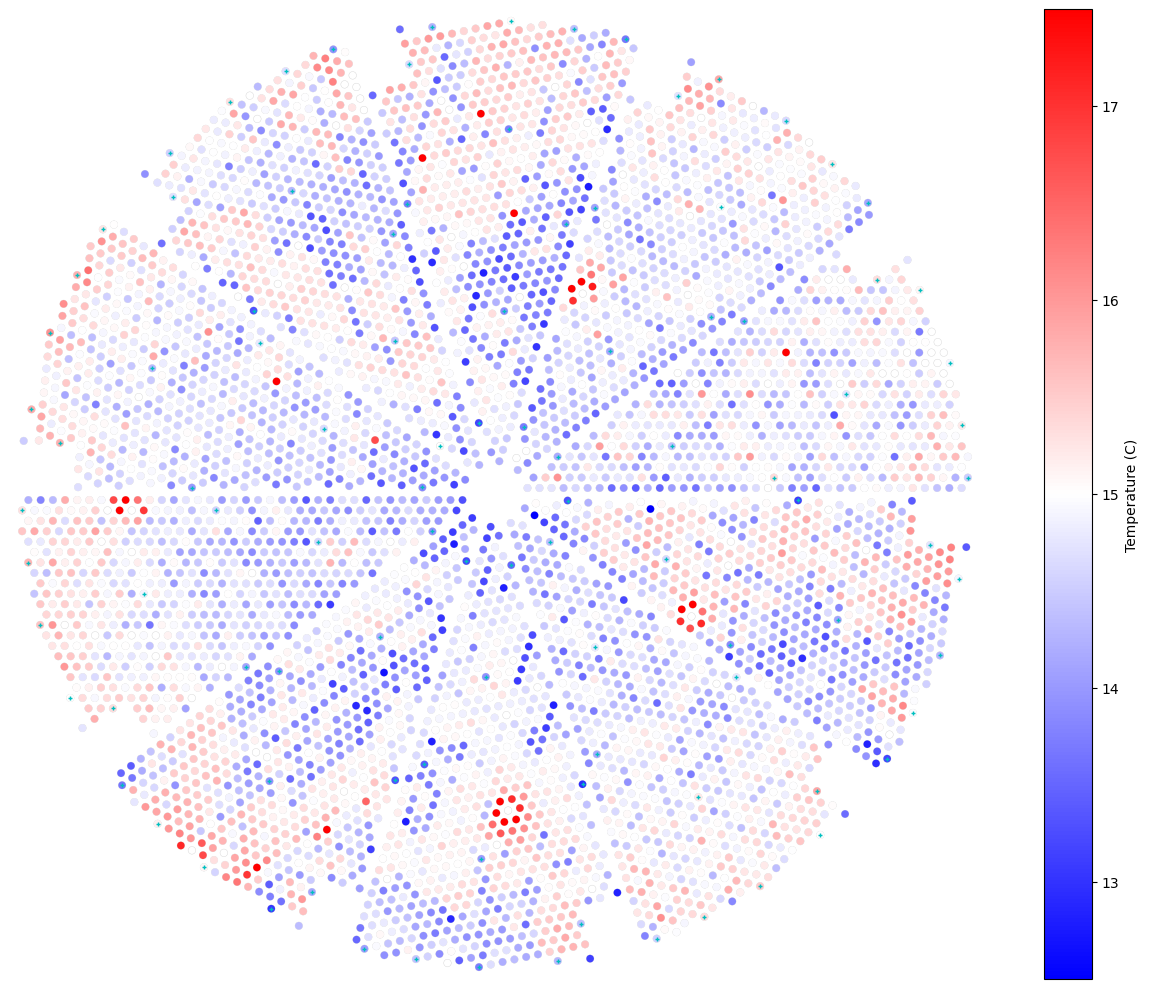

In [155]:
plot_vs_xy(adjust_calib=True) #, vmin=13.5, vmax=16.5)